In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, InputLayer, BatchNormalization, Dropout

from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_X_train = pd.read_csv('/content/drive/MyDrive/Research Trends/Data/df_X_train.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/Research Trends/Data/df_X_test.csv')
df_y_train = pd.read_csv('/content/drive/MyDrive/Research Trends/Data/df_y_train.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/Research Trends/Data/df_y_test.csv')

In [5]:
df_X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,160000.0,2,2,2,32,0,0,0,0,0,...,155404.0,153234.0,156731.0,155818.0,6000.0,6000.0,5600.0,6000.0,6000.0,5500.0
1,100000.0,2,1,2,30,0,0,0,0,2,...,42283.0,51539.0,50583.0,52588.0,5000.0,10000.0,10000.0,0.0,2846.0,1936.0
2,80000.0,1,1,2,29,0,0,0,0,0,...,64277.0,45455.0,42231.0,42804.0,3300.0,2500.0,1556.0,1600.0,1600.0,1600.0
3,20000.0,2,2,1,27,0,0,-1,-1,-2,...,780.0,0.0,0.0,0.0,1006.0,780.0,0.0,0.0,0.0,0.0
4,50000.0,2,1,2,30,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,2070.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_train = df_X_train.values
X_test = df_X_test.values
y_train = df_y_train.values
y_test = df_y_test.values

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
np.isnan(y_train).sum()

0

In [9]:
model = Sequential()

In [10]:
model.add(InputLayer(input_shape=(X_train.shape[1], )))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
sgd=optimizers.SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3072      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight = 'balanced', classes = class_labels, y = np.ravel(y_train))

# Convert to dictionary format
class_weight_dict = dict(enumerate(class_weights))

In [15]:
class_weights

array([0.6420055 , 2.26049516])

In [16]:
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], class_weight=class_weight_dict, verbose=2)


Epoch 1/100
657/657 - 6s - loss: 0.7176 - accuracy: 0.4609 - 6s/epoch - 9ms/step
Epoch 2/100
657/657 - 3s - loss: 0.6561 - accuracy: 0.5865 - 3s/epoch - 4ms/step
Epoch 3/100
657/657 - 3s - loss: 0.6359 - accuracy: 0.6381 - 3s/epoch - 4ms/step
Epoch 4/100
657/657 - 3s - loss: 0.6259 - accuracy: 0.6627 - 3s/epoch - 4ms/step
Epoch 5/100
657/657 - 3s - loss: 0.6194 - accuracy: 0.6760 - 3s/epoch - 5ms/step
Epoch 6/100
657/657 - 4s - loss: 0.6146 - accuracy: 0.6900 - 4s/epoch - 6ms/step
Epoch 7/100
657/657 - 3s - loss: 0.6106 - accuracy: 0.7082 - 3s/epoch - 4ms/step
Epoch 8/100
657/657 - 3s - loss: 0.6073 - accuracy: 0.7192 - 3s/epoch - 5ms/step
Epoch 9/100
657/657 - 3s - loss: 0.6046 - accuracy: 0.7286 - 3s/epoch - 4ms/step
Epoch 10/100
657/657 - 3s - loss: 0.6022 - accuracy: 0.7339 - 3s/epoch - 5ms/step
Epoch 11/100
657/657 - 3s - loss: 0.6001 - accuracy: 0.7403 - 3s/epoch - 5ms/step
Epoch 12/100
657/657 - 2s - loss: 0.5982 - accuracy: 0.7456 - 2s/epoch - 3ms/step
Epoch 13/100
657/657 - 2s

In [17]:
predictions = model.predict(X_test)

282/282 [==============================] - 1s 3ms/step


In [18]:
y_pred = (predictions > 0.5).astype(int)

In [19]:
cm = confusion_matrix(y_test, y_pred)

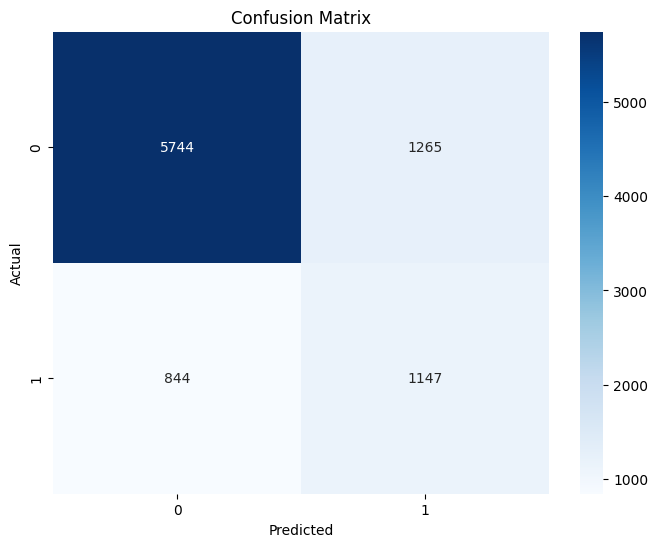

In [20]:
# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
explainer = shap.DeepExplainer(model, data=X_train)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [22]:
shap_values = explainer.shap_values(X_test)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


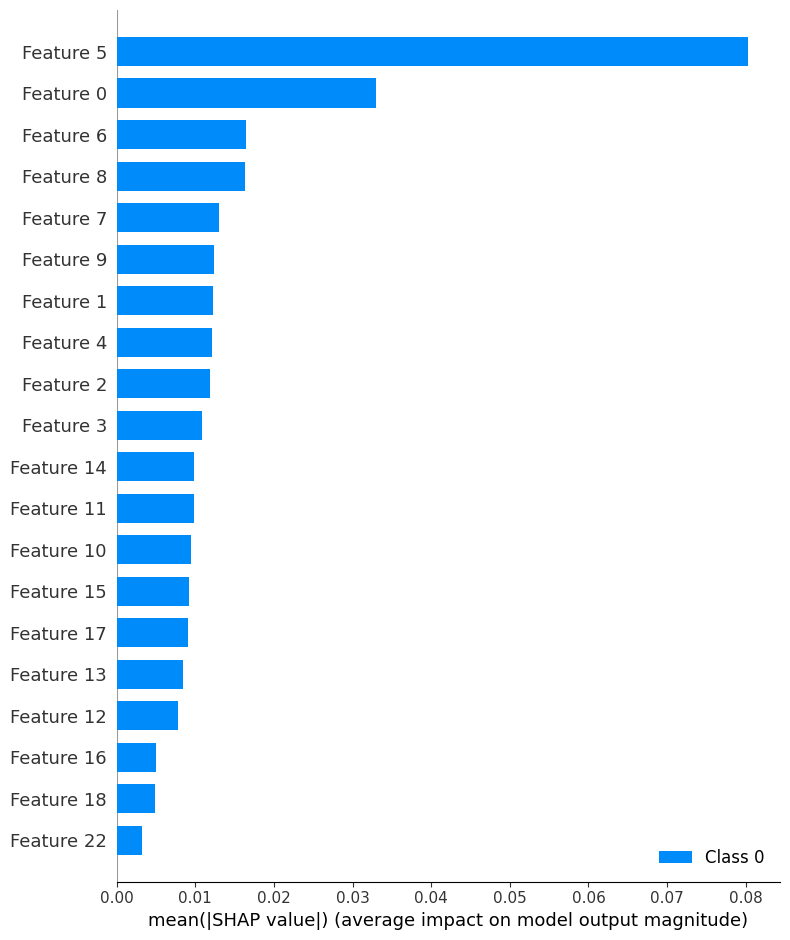

In [23]:
shap.summary_plot(shap_values, X_test)

In [28]:
feature_dict = {index: name for index, name in enumerate(df_X_train.columns)}

In [29]:
print(feature_dict)

{0: 'LIMIT_BAL', 1: 'SEX', 2: 'EDUCATION', 3: 'MARRIAGE', 4: 'AGE', 5: 'PAY_0', 6: 'PAY_2', 7: 'PAY_3', 8: 'PAY_4', 9: 'PAY_5', 10: 'PAY_6', 11: 'BILL_AMT1', 12: 'BILL_AMT2', 13: 'BILL_AMT3', 14: 'BILL_AMT4', 15: 'BILL_AMT5', 16: 'BILL_AMT6', 17: 'PAY_AMT1', 18: 'PAY_AMT2', 19: 'PAY_AMT3', 20: 'PAY_AMT4', 21: 'PAY_AMT5', 22: 'PAY_AMT6'}


In [24]:
import pickle

# Assuming you have trained your model and stored it in the 'model' variable

# Save the model using pickle
with open('model_credit_card_default.pkl', 'wb') as file:
    pickle.dump(model, file)

In [30]:
!mv "/content/model_credit_card_default.pkl" "/content/drive/MyDrive/Research Trends/Models/model_credit_card_default.pkl"
